## Violations Search Tau Macro

> Written by Jess Breda September 2023

For this notebook, I am working based on the to-dos from 2023-08-29 meeting and previous notebook `2023_08_violations_feature_analysis`/

The goals for this NB are

1. Update & test code to only apply exp filter to a session at a time

2. Update code to normalize all together before train test split. This might mean changing the order in generate_design_matrix. 
    * Or just a function that takes a list of dfs and finds the max value and normalize them by it?
    * Or just pass in the generated design matrix into train test split

3. Iterate over a finer grid of taus and sigmas

sigmas = 0.01, 0.1, 0.2, 0.5, 1, 1.5, 2, 2.5, 3, 5

taus = 1, 2, 3, 5, 10, 12, 15, 17, 20, 25, 30

In [30]:
import pathlib
import platform
import sys
[
    sys.path.append(str(folder))
    for folder in pathlib.Path("../src/").iterdir()
    if folder.is_dir()
]
import numpy as np
from matplotlib import pyplot as plt
import seaborn as sns
import pandas as pd

sns.set_context("talk")

from sklearn.model_selection import train_test_split

from generate_design_matrix import DesignMatrixGenerator, ExpFilter
from get_rat_data import *
from multiclass_logistic_regression import MultiClassLogisticRegression
from sigma_tau_search_experiment_violation import SigmaTauSearchExperimentViolation
from method_validation import plot_kernel_validation

MODE = "local"

# settings
%load_ext autoreload
%autoreload 2

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


### Apply exp filter on session by session basis

In [44]:
# Example usage
df = pd.DataFrame(
    {
        "session": [1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 2, 2, 2, 2, 2, 2, 2, 3, 3, 3, 3, 3],
        "violation": np.random.randint(0, 2, 22),
    }
)
session_boundaries_mask = df["session"].diff() == 0

df["prev_violation"] = (df.violation.shift() * session_boundaries_mask).fillna(0)

tau = 4
filter_obj = ExpFilter(tau=tau, column="prev_violation")
filter_obj.apply_filter_to_dataframe(df)

Exp filter added for session 1 | Column: prev_violation, Tau: 4
Exp filter added for session 2 | Column: prev_violation, Tau: 4
Exp filter added for session 3 | Column: prev_violation, Tau: 4


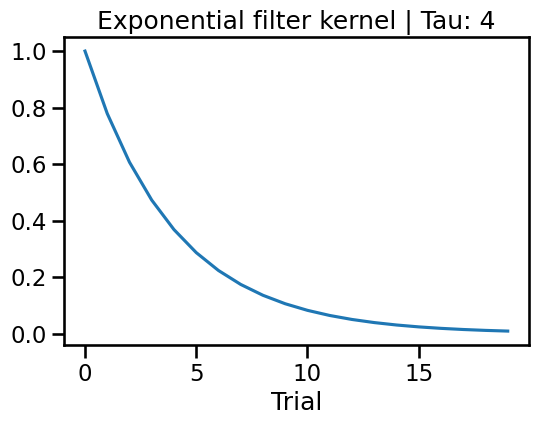

In [45]:
filter_obj.plot_kernel()

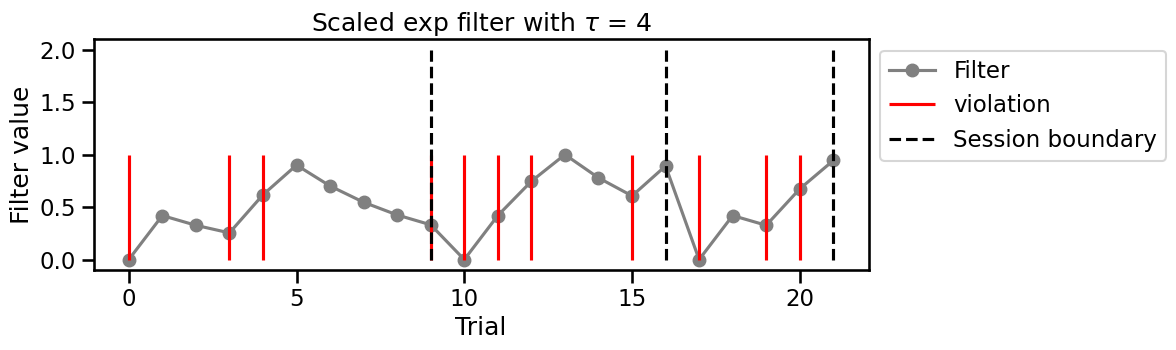

In [48]:
plot_kernel_validation(df, f"prev_violation_exp_{tau}")

In [9]:
params = {
    "animals": None,
    "sigmas": [0.13, 0.25, 0.5, 1, 2, 4, 8, 16],
    "taus": [0, 1, 2, 3, 4, 5, 6, 7, 8, 10, 9, 11, 12],
    "random_state": 47,
    "test_size": 0.25,
}

full_experiment = SigmaTauSearchExperimentViolation(params)
results = full_experiment.run()

returning dataset for all animals


 !!!!! evaluating animal W051 !!!!!


sigma: 0.13, tau: 0, size of X: (55433, 7), Y: (55433, 3)
Optimization terminated successfully.
         Current function value: 39058.881852
         Iterations: 22
         Function evaluations: 37
         Gradient evaluations: 37
sigma: 0.13, tau: 1, size of X: (55433, 8), Y: (55433, 3)
Optimization terminated successfully.
         Current function value: 38184.761421
         Iterations: 24
         Function evaluations: 37
         Gradient evaluations: 37
sigma: 0.13, tau: 2, size of X: (55433, 8), Y: (55433, 3)
Optimization terminated successfully.
         Current function value: 38064.633319
         Iterations: 23
         Function evaluations: 35
         Gradient evaluations: 35
sigma: 0.13, tau: 3, size of X: (55433, 8), Y: (55433, 3)
Optimization terminated successfully.
         Current function value: 38054.209172
         Iterations: 24
         Function evaluations: 33
         Gradient evalua

In [10]:
full_experiment.animals

array(['W051', 'W060', 'W061', 'W062', 'W065', 'W066', 'W068', 'W072',
       'W073', 'W074', 'W075', 'W078', 'W080', 'W081', 'W082', 'W083',
       'W088', 'W089', 'W094'], dtype=object)

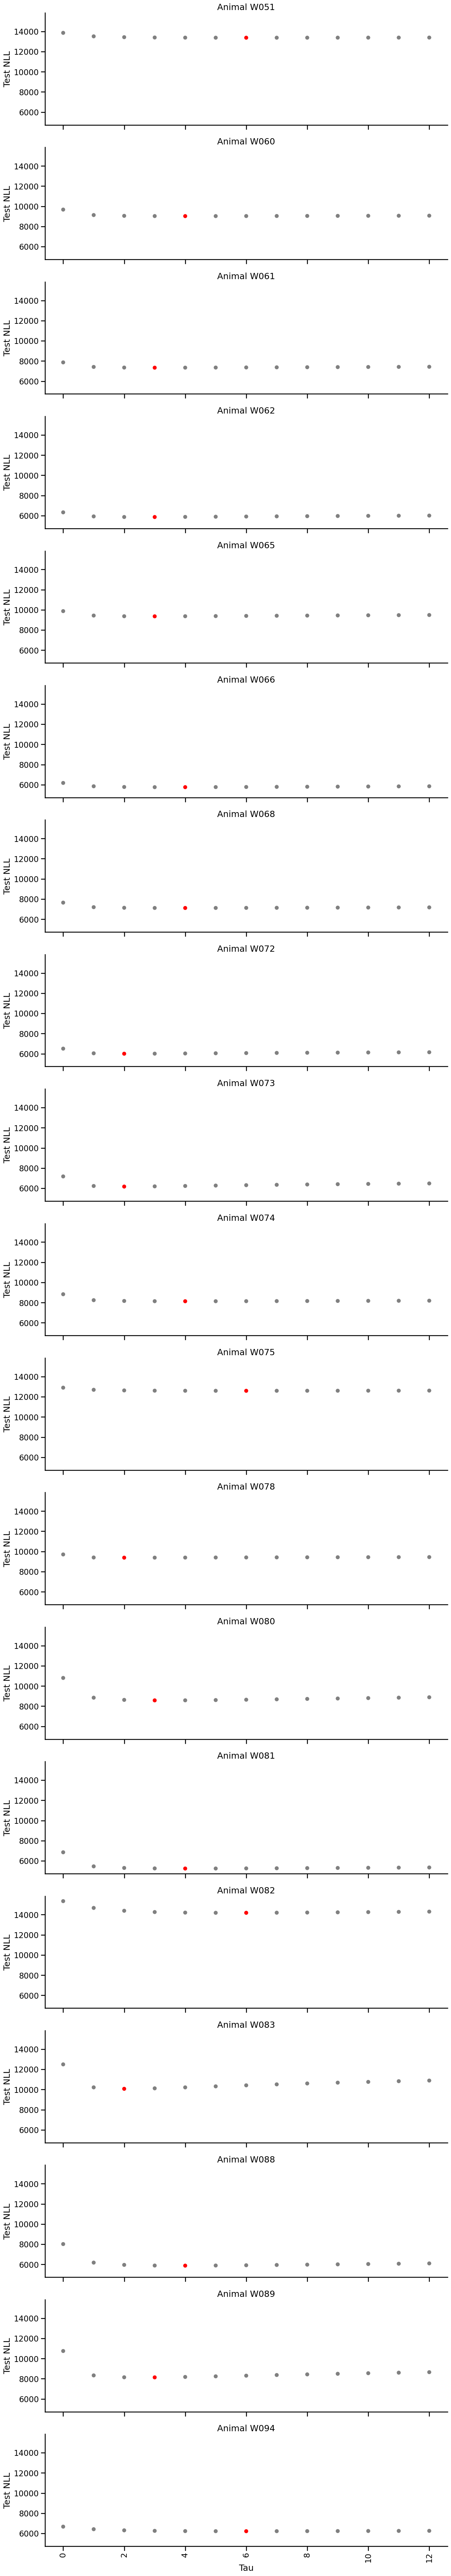

In [11]:
full_experiment.plot_nll_over_taus()

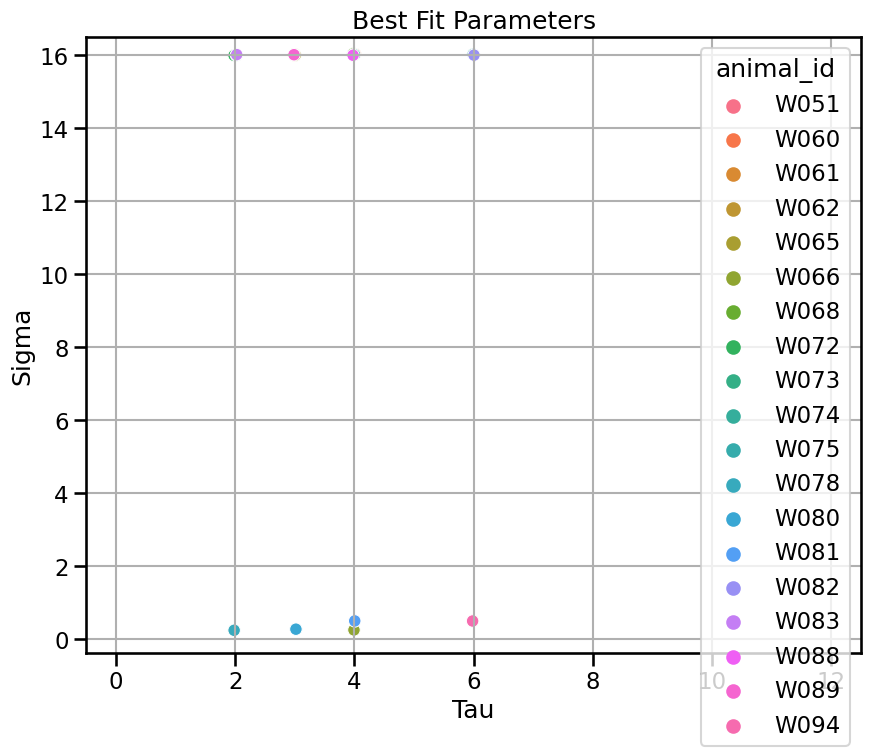

In [12]:
full_experiment.plot_best_sigma_tau_by_animal(jitter=0.025)

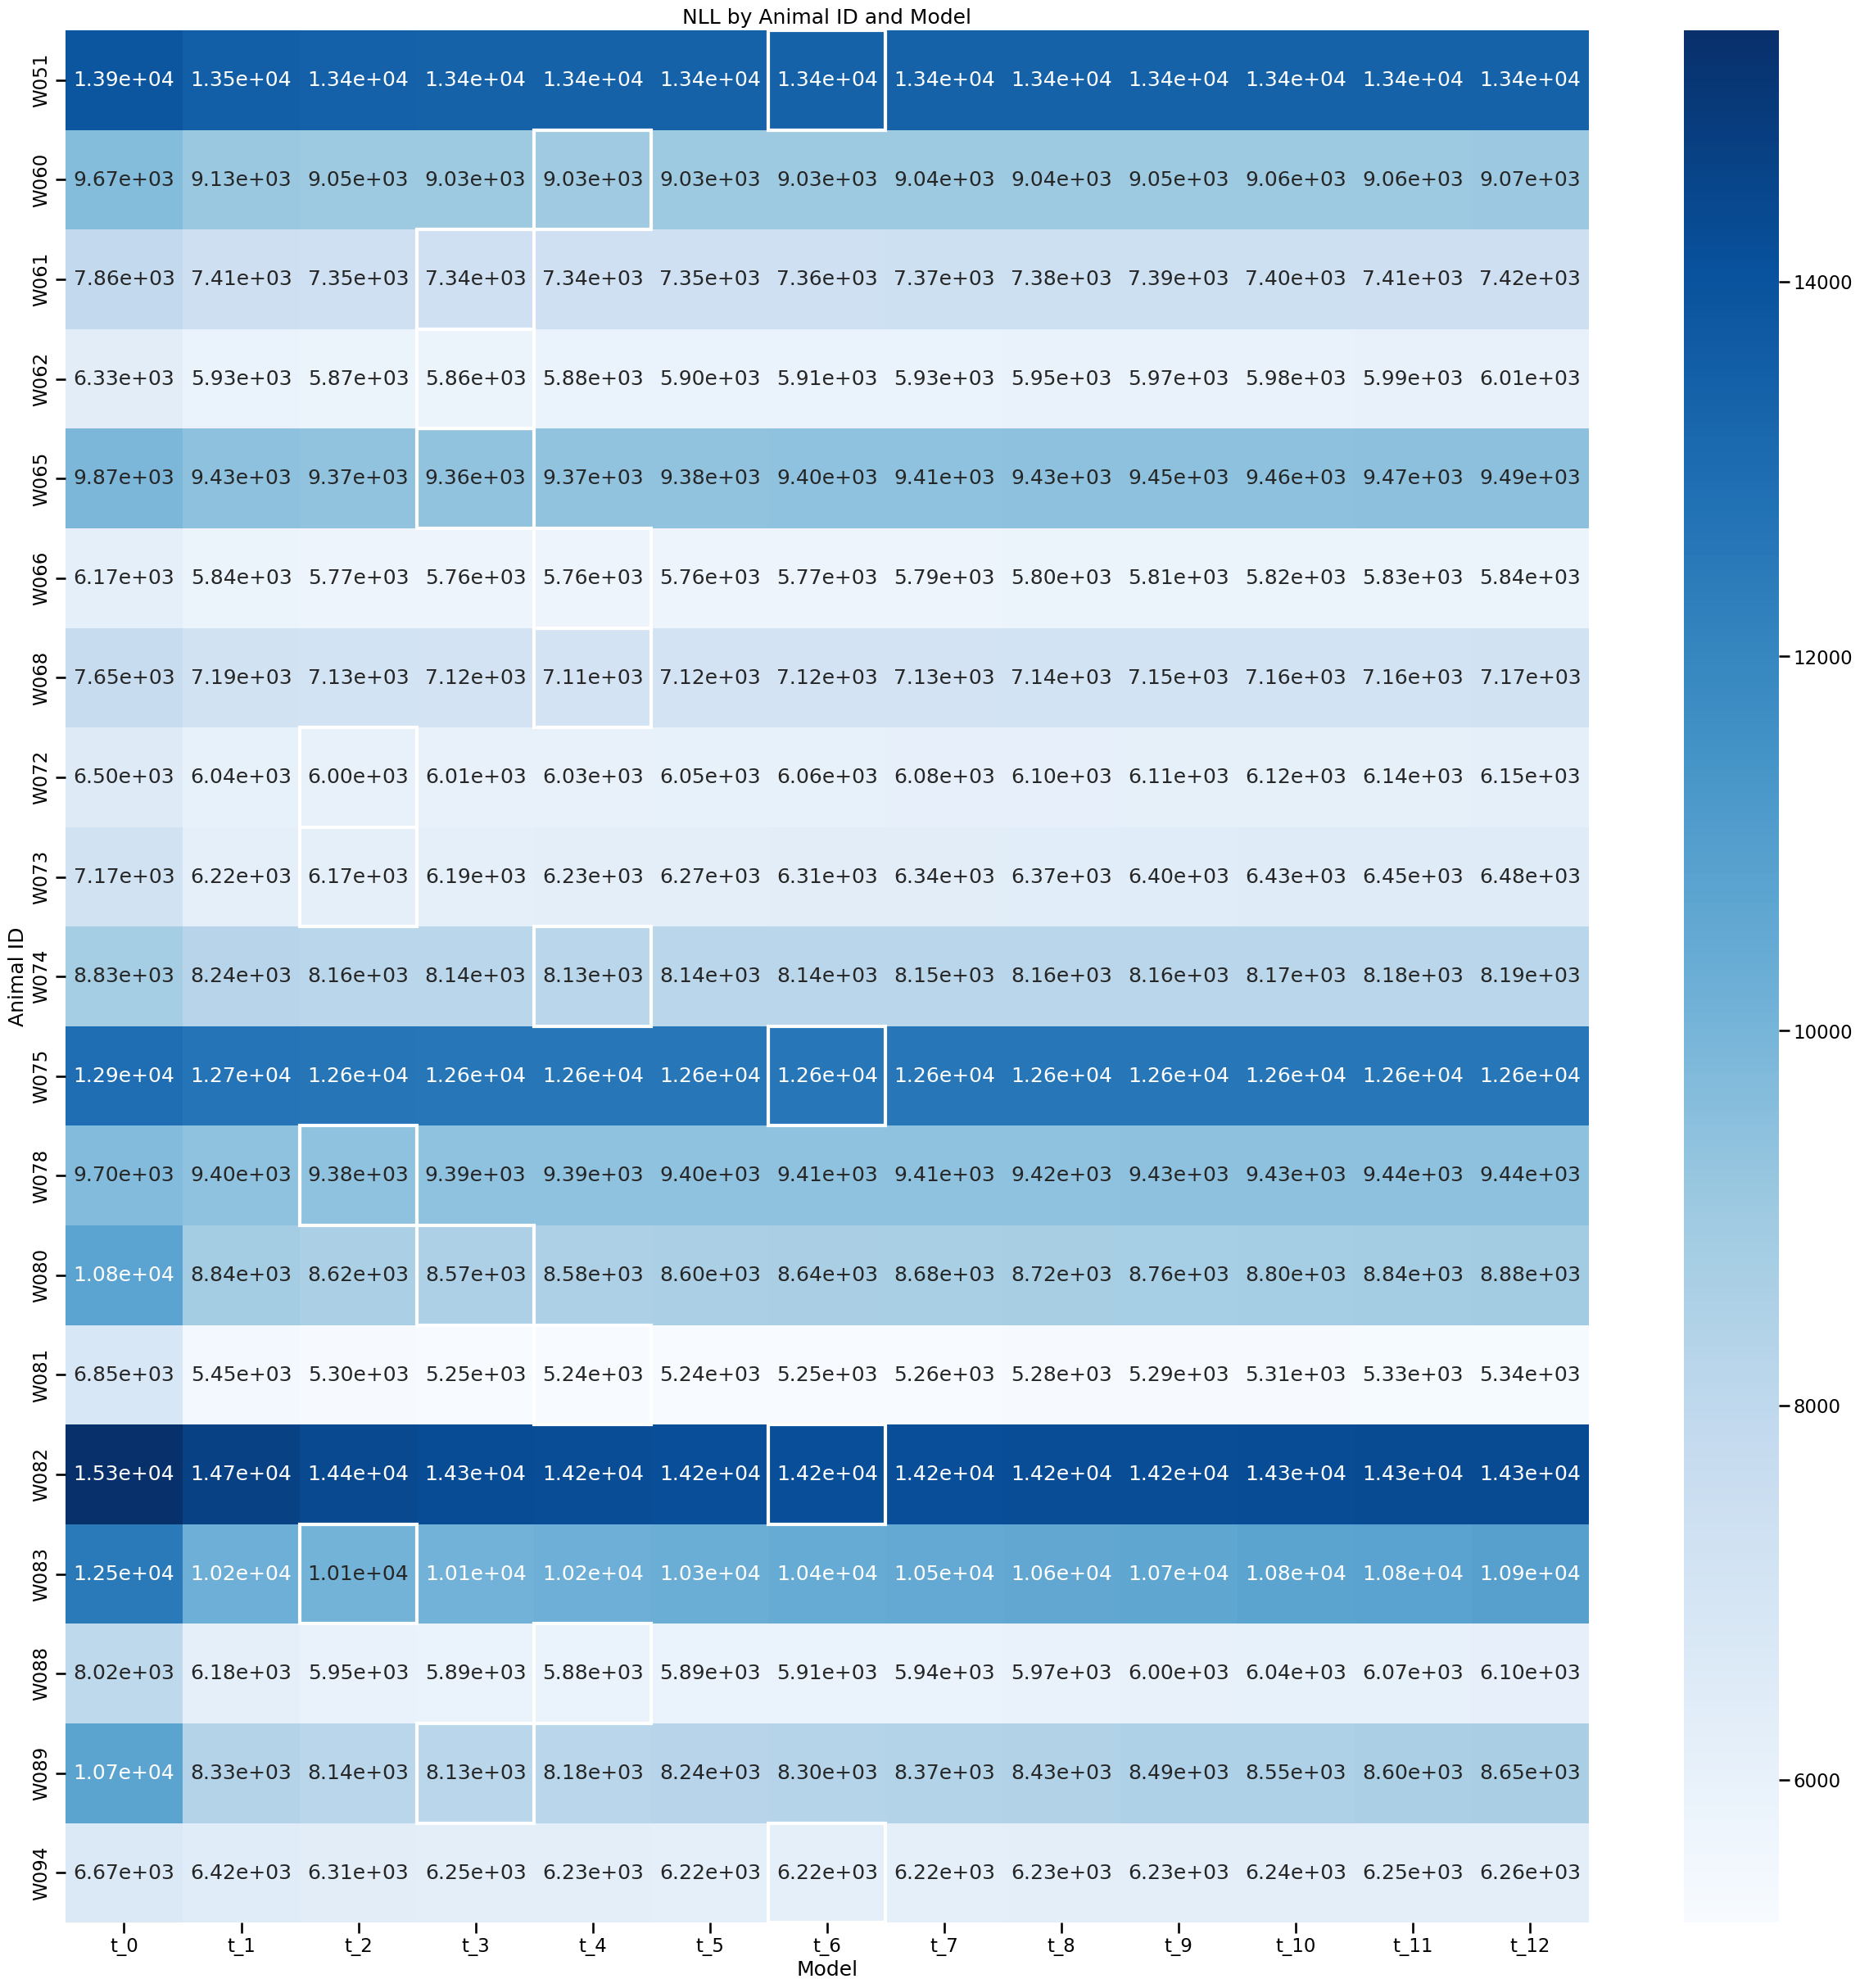

In [16]:
full_experiment.plot_tau_heatmap()

In [17]:
full_experiment.find_best_fit(group="animal_id")

,animal_id,model_name,sigma,tau,nll
0,W051,t_6,16.00,6,13377.834257
1,W060,t_4,16.00,4,9026.235886
2,W061,t_3,16.00,3,7335.090216
3,W062,t_3,16.00,3,5864.827789
4,W065,t_3,16.00,3,9357.395909
5,W066,t_4,0.25,4,5755.830700
6,W068,t_4,16.00,4,7113.950009
7,W072,t_2,16.00,2,6001.669140
8,W073,t_2,16.00,2,6166.914478
9,W074,t_4,16.00,4,8134.925294


In [23]:
"/Users/jessbreda/Desktop/github/animal-learning/data/results/2023_09_violations_search_tau_macro.csv"

'/Users/jessbreda/Desktop/github/animal-learning/data/results/2023_09_violations_search_tau_macro.csv'

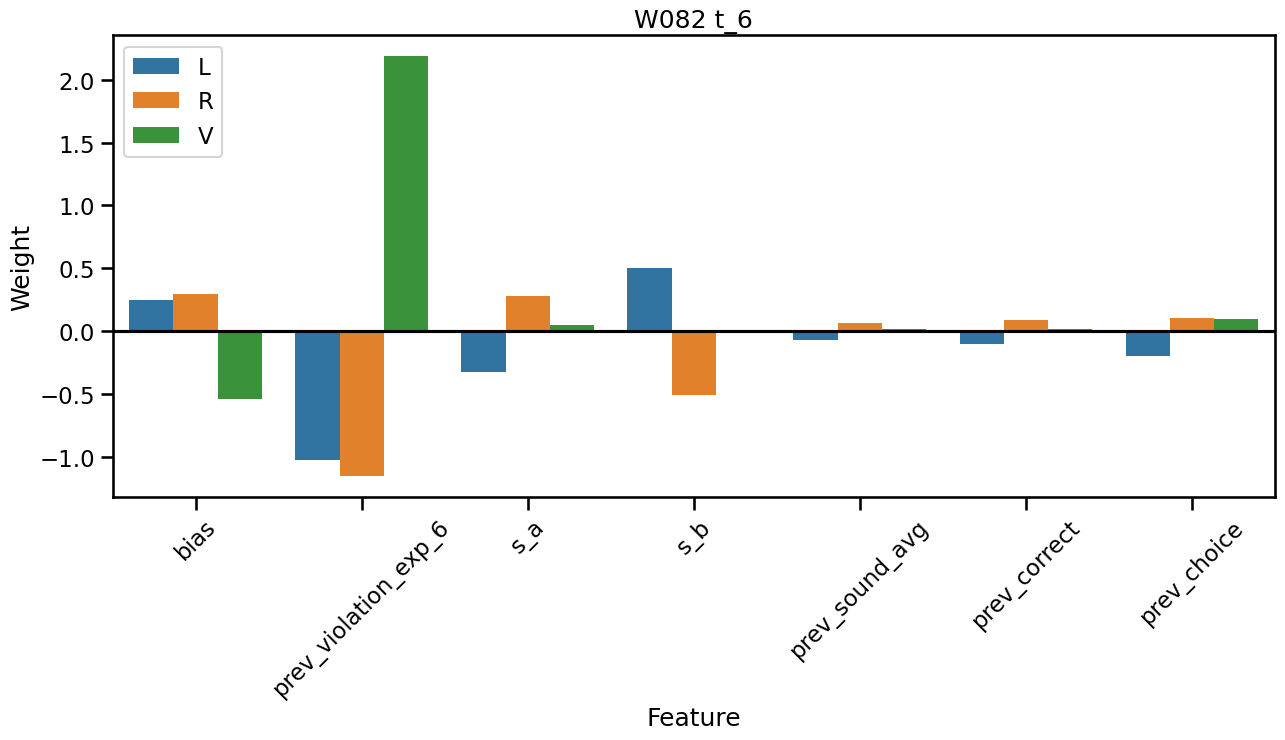

In [19]:
full_experiment.plot_class_weights(animal_id="W082", model_name="t_6")

In [25]:
results.to_csv(
    "/Users/jessbreda/Desktop/github/animal-learning/data/results/2023_09_violations_search_tau_macro.csv",
    index=False,
)

In [28]:
best_fits = full_experiment.find_best_fit(group="animal_id")

best_fits[["animal_id", "tau"]].to_csv(
    "/Users/jessbreda/Desktop/github/animal-learning/data/results/prev_violation_tau.csv",
    index=False,
)

In [29]:
pd.read_csv(
    "/Users/jessbreda/Desktop/github/animal-learning/data/results/prev_violation_tau.csv"
)

,animal_id,tau
0,W051,6
1,W060,4
2,W061,3
3,W062,3
4,W065,3
5,W066,4
6,W068,4
7,W072,2
8,W073,2
9,W074,4


In [54]:
best_fits

,animal_id,model_name,sigma,tau,nll
0,W051,t_6,16.00,6,13377.834257
1,W060,t_4,16.00,4,9026.235886
2,W061,t_3,16.00,3,7335.090216
3,W062,t_3,16.00,3,5864.827789
4,W065,t_3,16.00,3,9357.395909
5,W066,t_4,0.25,4,5755.830700
6,W068,t_4,16.00,4,7113.950009
7,W072,t_2,16.00,2,6001.669140
8,W073,t_2,16.00,2,6166.914478
9,W074,t_4,16.00,4,8134.925294


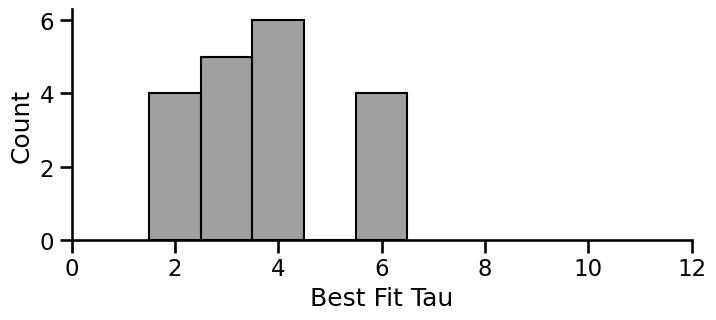

In [71]:
fig, ax = plt.subplots(figsize=(8, 3))
sns.histplot(
    best_fits["tau"], ax=ax, bins=10, kde=False, binwidth=1, discrete=True, color="gray"
)
ax.set_xlim(0, 12)
ax.set(xlabel="Best Fit Tau")
sns.despine()

In [73]:
best_fits.tau.median()

4.0

In [49]:
best_fits

,animal_id,model_name,sigma,tau,nll
0,W051,t_6,16.00,6,13377.834257
1,W060,t_4,16.00,4,9026.235886
2,W061,t_3,16.00,3,7335.090216
3,W062,t_3,16.00,3,5864.827789
4,W065,t_3,16.00,3,9357.395909
5,W066,t_4,0.25,4,5755.830700
6,W068,t_4,16.00,4,7113.950009
7,W072,t_2,16.00,2,6001.669140
8,W073,t_2,16.00,2,6166.914478
9,W074,t_4,16.00,4,8134.925294
